/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle est


Random Forest Model Performance Metrics (Cutoff=0.55):
--------------------------------------------------
AUC: 0.7780
Balanced Accuracy: 0.7021
Sensitivity: 0.7551
Specificity: 0.6491
Confusion Matrix:
[[37 20]
 [12 37]]

Random Forest Model Performance Metrics (Cutoff=0.6):
--------------------------------------------------
AUC: 0.7893
Balanced Accuracy: 0.7166
Sensitivity: 0.7917
Specificity: 0.6415
Confusion Matrix:
[[34 19]
 [10 38]]

Random Forest Model Performance Metrics (Cutoff=0.65):
--------------------------------------------------
AUC: 0.7680
Balanced Accuracy: 0.6978
Sensitivity: 0.7556
Specificity: 0.6400
Confusion Matrix:
[[32 18]
 [11 34]]

Random Forest Model Performance Metrics (Cutoff=0.7):
--------------------------------------------------
AUC: 0.7457
Balanced Accuracy: 0.6912
Sensitivity: 0.7442
Specificity: 0.6383
Confusion Matrix:
[[30 17]
 [11 32]]


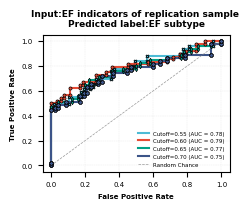

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score, confusion_matrix
import pandas as pd
from sklearn.preprocessing import StandardScaler

def load_data(file_path):
    """加载并预处理数据"""
    # 读取followup数据
    followup_df = pd.read_excel(file_path, sheet_name='Followup')
    followup_df = followup_df[followup_df['Label-0.65'] != 3]
    
    # 定义特征
    features = ['Stroop_incongruent_rt', 'Stroop_interference effect_rt', 'Nogo_acc',
                'Switch_cost', 'RM-1,750_acc', 'RM-750_acc', 'DSBT_Span']
    X_followup = followup_df[features]
    y_followup = followup_df['Label-0.65']
    return X_followup, y_followup

def load_models(model_path):
    """加载训练好的模型"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return {'RF': model}

def calculate_metrics(y_true, y_pred_prob):
    """计算各项评估指标"""
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # 计算AUC
    auc = roc_auc_score(y_true, y_pred_prob)
    
    # 计算BAC
    bac = balanced_accuracy_score(y_true, y_pred)
    
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    
    # 计算sensitivity和specificity
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # TPR
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TNR
    
    return {
        'AUC': auc,
        'BAC': bac,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Confusion Matrix': cm
    }

def plot_rf_roc_curves(model_dicts, X_followups, y_followups, cutoffs):
    """绘制多个cutoff下RF模型的ROC曲线并输出评估指标"""
    plt.figure(figsize=(2.5, 2.2))
    
    # Nature配色方案
    colors = [ '#4DBBD5','#E64B35', '#00A087', '#3C5488', '#F39B7F', '#8491B4']
    linestyles = ['-', '-', '-', '-']
    markers = ['X', 'o', 'd', 'P']  # 每个 cutoff 用不同的 marker
    
    for i, cutoff in enumerate(cutoffs):
        model_dict = model_dicts[i]
        X_followup = X_followups[i]
        y_followup = y_followups[i]
        
        print(f"\nRandom Forest Model Performance Metrics (Cutoff={cutoff}):")
        print("-" * 50)
        
        # 使用保存的scaler转换数据
        X_scaled = pd.DataFrame(
            model_dict['RF']['scaler'].transform(X_followup),
            columns=X_followup.columns,
            index=X_followup.index
        )
        
        # 获取预测概率
        y_pred_prob = model_dict['RF']['clf'].predict_proba(X_scaled)[:, 1]
        
        # 计算评估指标
        metrics = calculate_metrics(y_followup, y_pred_prob)
        
        # 打印评估指标
        print(f"AUC: {metrics['AUC']:.4f}")
        print(f"Balanced Accuracy: {metrics['BAC']:.4f}")
        print(f"Sensitivity: {metrics['Sensitivity']:.4f}")
        print(f"Specificity: {metrics['Specificity']:.4f}")
        print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")
        
        # 计算ROC曲线
        fpr, tpr, thresholds = roc_curve(y_followup, y_pred_prob)

        # 绘制ROC曲线 (添加图例仅在此处)
        plt.plot(fpr, tpr, color=colors[i], linestyle=linestyles[i], lw=1.5, alpha=1, 
                 label=f'Cutoff={cutoff:.2f} (AUC = {metrics["AUC"]:.2f})')
        
        # 在每个点添加 marker，但不添加图例
        for j, (fp, tp) in enumerate(zip(fpr, tpr)):
            plt.scatter(fp, tp, color=colors[i], marker=markers[i], s=5, label='', zorder=10, alpha=1, edgecolors='black', linewidths=0.5)

    # 绘制随机分类器的基准线
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', alpha=0.8, lw=0.5,
             label='Random Chance')
    
    # 设置图形属性  
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.tick_params(axis='both', which='major', labelsize=5)  # 设置刻度字体大小
    plt.xlabel('False Positive Rate', fontsize=5, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=5, fontweight='bold')
    plt.title('Input:EF indicators of replication sample \nPredicted label:EF subtype', fontsize=6.5, fontweight='bold', pad=6)
    
    # 添加网格
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.3)
    
    # 优化图例 (移除 marker 的重复条目)
    plt.legend(loc='lower right', frameon=False, fancybox=False,
              framealpha=0.8, fontsize=4)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存和显示
    plt.savefig('对比_ROC_Nature_with_markers_removed.jpg', dpi=2200, bbox_inches='tight')
    plt.show()
    
    
    

def main():
    # 定义cutoff和相关路径

    cutoffs = [0.55, 0.60, 0.65, 0.70]
    data_paths = [
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.55/rawdata.xlsx',
        '//Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.60/rawdata.xlsx',
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.65/rawdata.xlsx',
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.70/rawdata.xlsx'
    ]
    model_paths = [
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.55/model_history_followup/RF_best.pkl',
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.60/model_history_followup/RF_best.pkl',
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.65/model_history_followup/RF_best.pkl',
        '/Users/zhangtongyi/Desktop/P0022024-认知聚类-project(最新版）/A.最新版本/2.主结果/2.基线-数据分析/3.聚类后分析/Classification analyses of EF subtypes /cutoff=0.70/model_history_followup/RF_best.pkl'
    ]


    # 加载数据和模型
    X_followups = []
    y_followups = []
    model_dicts = []
    
    for data_path, model_path in zip(data_paths, model_paths):
        X_followup, y_followup = load_data(data_path)
        model_dict = load_models(model_path)
        
        X_followups.append(X_followup) 
        y_followups.append(y_followup)
        model_dicts.append(model_dict)
    
    # 绘制ROC曲线并输出评估指标
    plot_rf_roc_curves(model_dicts, X_followups, y_followups, cutoffs)

if __name__ == "__main__":
    main()

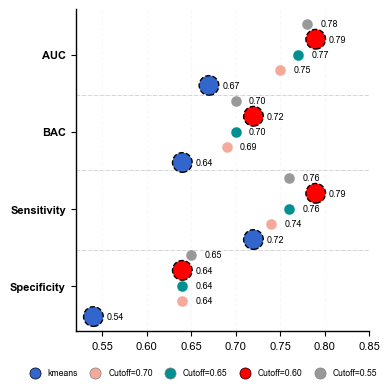

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D  # 新增关键导入

# Set custom style for Nature-quality visualization
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 10
rcParams['axes.linewidth'] = 1
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 10
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.3
rcParams['grid.linestyle'] = '--'

# Data for RF only
metrics_names = ['Specificity', 'Sensitivity', 'BAC', 'AUC']
cutoffs = ['0.55', '0.60', '0.65', '0.70', 'kmeans']

# Updated values from the new data
values = {
    '0.55': [0.65, 0.76, 0.70, 0.78],
    '0.60': [0.64, 0.79, 0.72, 0.79],
    '0.65': [0.64, 0.76, 0.70, 0.77],
    '0.70': [0.64, 0.74, 0.69, 0.75],
    'kmeans':[0.54, 0.72, 0.64, 0.67],
}

# Nature-style color palette
colors = ['#999999', 'red', '#019092', '#F4A99B', '#3366CC']

# Create figure
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, facecolor='white')

# Plot markers
base_y = np.arange(len(metrics_names)) * 7.5
marker_offset = 1.5
markers = []

# Add horizontal lines between metrics
separation_lines = [6.49, 14.3, 21.6]
for y_position in separation_lines:
    ax.axhline(y=y_position, color='gray', linestyle='-.', linewidth=0.4, alpha=0.6)

# Modified plotting logic
for i, cutoff in enumerate(reversed(cutoffs)):
    y_positions = base_y + (i * marker_offset)
    
    # 保持原始绘图逻辑不变
    if cutoff == '0.60' or cutoff == 'kmeans':
        scatter = ax.scatter(values[cutoff], y_positions, 
                            marker='o',
                            s=200,
                            color=colors[len(colors)-1-i],
                            label=cutoff if cutoff == 'kmeans' else f'Cutoff={cutoff}',
                            edgecolor='black',
                            linewidth=1,linestyle='--')
    else:
        scatter = ax.scatter(values[cutoff], y_positions, 
                            marker='o',
                            s=60,
                            color=colors[len(colors)-1-i],
                            label=cutoff if cutoff == 'kmeans' else f'Cutoff={cutoff}',
                            edgecolor='white',
                            linewidth=0.1)
    markers.append(scatter)

    # Add value labels
    for j, value in enumerate(values[cutoff]):
        ax.text(value + 0.015, y_positions[j],
                f'{value:.2f}',
                ha='left',
                va='center',
                fontsize=6.5)

# 关键修改部分：创建统一尺寸的图例句柄
legend_elements = [
    Line2D([0], [0],
           marker='o',
           color='w',
           label='kmeans' if label == 'kmeans' else f'Cutoff={label}',
           markerfacecolor=color,
           markersize=8,  # 统一标记尺寸
           markeredgewidth=0.5,
           markeredgecolor='black' if (label == '0.60' or label == 'kmeans') else 'gray')
    for label, color in zip(reversed(cutoffs), reversed(colors))
]

# 应用自定义图例
leg = ax.legend(handles=legend_elements,
                bbox_to_anchor=(0.43, -0.13),
                loc='center',
                borderaxespad=0.5,
                frameon=False,
                fancybox=True,
                ncol=5,
                columnspacing=1,
                handletextpad=0.5,
                fontsize=6.2)

# 保留其他样式设置
ax.set_yticks(base_y + (len(cutoffs)-1) * marker_offset/2)
ax.set_yticklabels(metrics_names, fontweight='bold')
ax.set_xlim(0.52, 0.85)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.xaxis.grid(True, linestyle='--', alpha=0.05, color='gray')
ax.yaxis.grid(False)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('nature_style_metrics_unified_legend.jpg',
            dpi=2200,
            bbox_inches='tight',
            transparent=False)

plt.show()